In [222]:
from google.colab import drive
import os
drive.mount('/content/drive/', force_remount=False)

#put the path to the directory with .csv files and 'images' folder on your google drive
datapath = '/content/drive/My Drive/ai-side-projects/kitchenware_classification/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Loading data

In [223]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

def show(image, label, label_pred=None):
    plt.figure()
    plt.imshow(image)

    if label_pred is not None:
      label_pred = label_pred*100
      label_pred = np.round(label_pred,1)
      plt.title(f"Actual (One-hot): {label.numpy()}, Predicted (%): {label_pred}")
    else:
      plt.title(f"Actual: {label.numpy()}")

    plt.axis('off')
    plt.show()

 join pandas dataframes with image IDs and filenames for test and train

In [224]:
train_labels = pd.read_csv(datapath + '/data/train.csv', index_col=0)
train_labels['filename'] = [datapath+'data/images/'+str(train_labels.index.values[i]) + '.jpg' for i in range(len(train_labels))]

test_labels = pd.read_csv(datapath + '/data/test.csv', index_col=0)
test_labels['label'] = 'TEST'
test_labels['filename'] = [datapath+'data/images/'+str(test_labels.index.values[i]) + '.jpg' for i in range(len(test_labels))]

all_labels = pd.concat([train_labels, test_labels])


create a Dataset generator and one-hot encoding

In [225]:
list_ds = tf.data.Dataset.list_files(datapath+'data/images/*.jpg')

classNames = ['glass', 'cup', 'spoon', 'plate', 'knife', 'fork', 'TEST']


def parse_image(filename):
    filename_jpg = tf.strings.split(filename, os.sep)[-1]
    id_str = tf.strings.split(filename_jpg, '.')[0]
    id = tf.strings.to_number(id_str, out_type=tf.int32)  # Convert string to int

    # Gather the label using TensorFlow operations
    mask = all_labels.index == id
    label = tf.boolean_mask(all_labels['label'].values, mask)[0]

    image = tf.io.read_file(filename)
    image = tf.io.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [128, 128])
    return image, label


def one_hot_encode(image, label):
    label_index = tf.argmax(tf.cast(tf.equal(classNames, label), tf.int32))
    one_hot_label = tf.one_hot(label_index, len(classNames)-1) # len(classNames)-1 because test label is excluded
    return image, one_hot_label


images_ds = list_ds.map(parse_image)

images_ds = images_ds.shuffle(len(all_labels))

def filter_out_label_test(image, label):
    return tf.math.logical_not(tf.math.equal(label, 'TEST'))

train_ds_orig = list_ds.map(parse_image).filter(filter_out_label_test)

train_ds_orig = train_ds_orig.map(one_hot_encode)


show a few examples

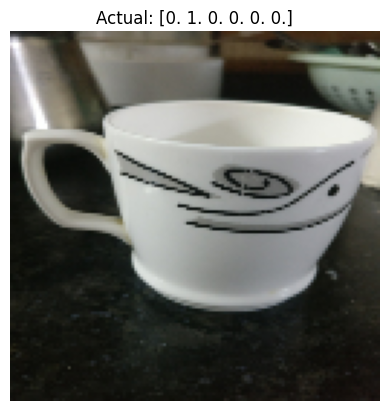

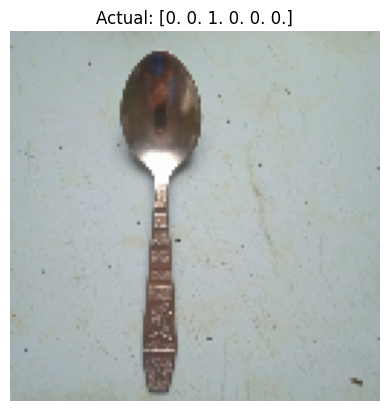

In [226]:
for image, label in train_ds_orig.take(2):
  show(image, label)

train/test/validation division

In [227]:
n_samples = len(all_labels.query('label!="TEST"'))
train_size = int(0.7 * n_samples)
val_size = int(0.15 * n_samples)
test_size = int(0.15 * n_samples)


batch_size = 32
img_height = 128
img_width = 128

#train_ds = train_ds_orig.take(train_size)
#test_ds = train_ds_orig.skip(train_size)
#val_ds = test_ds.skip(val_size)
#test_ds = test_ds.take(test_size)
train_ds = train_ds_orig.take(train_size)
val_ds = train_ds_orig.skip(train_size).take(val_size)
test_ds = train_ds_orig.skip(train_size + val_size).take(test_size)


train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

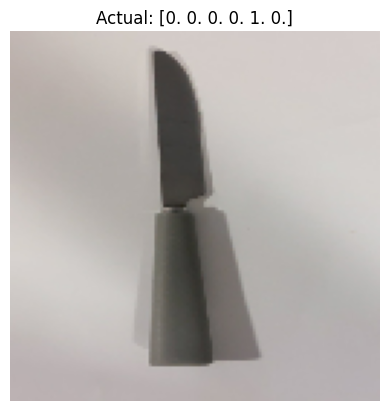

In [228]:
for image, label in val_ds.unbatch().take(1):
  pass
  show(image, label)


In [229]:
##cache images after first epoch
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(len(all_labels)).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Convolutional model

Note **data augmentation** in the training time - input image is randomly flipped horozontally, moved, rotated and zoomed slightly to increase the generalisation ability of the model. In my first attempts without data augmentation the model was barely achieving 65-70% accuracy.

I also noticed that the number of neurons in the second-to-last dense layer impacts the quality of the model significantly.

In [230]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


num_classes = len(classNames) - 1


data_augmentation = keras.Sequential(
  [
    #note that we can do vertical flip but only for forks, spoons or knives.
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    keras.layers.RandomTranslation(0.1,0.1),
    layers.RandomRotation(0.07),
    layers.RandomZoom(0.1),
  ]
)


model = Sequential([

  data_augmentation,

  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  layers.Conv2D(16, 3, strides = 2, padding='same', activation='relu'),

  #layers.MaxPooling2D(),

  layers.Conv2D(32, 3, strides = 2, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, strides = 2, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Dropout(0.2),

  layers.Flatten(),

  layers.Dense(128, activation='relu'),

  layers.Dense(num_classes, activation = 'softmax'),

])

model.compile(optimizer='adam',
              #loss=tf.keras.losses.CategoricalCrossentropy,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


data augmentation effect on one example

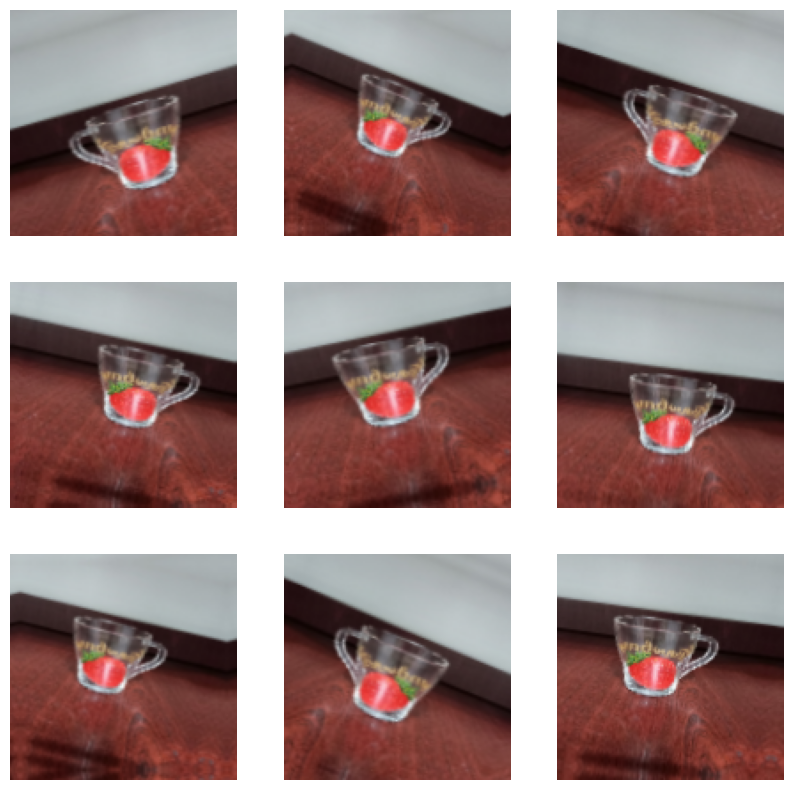

In [231]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((255*augmented_images[0].numpy()).astype("uint8"))
    plt.axis("off")

In [232]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_23 (Sequential)  (None, 128, 128, 3)       0         
                                                                 
 rescaling_16 (Rescaling)    (None, 128, 128, 3)       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 conv2d_49 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_46 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_50 (Conv2D)          (None, 8, 8, 64)          18496     
                                                     

In [234]:
epochs=300
history = model.fit(
  train_ds,
  epochs=epochs,
  shuffle = True,
  validation_data=val_ds,
)


Epoch 1/300
122/122 [==============================] - 54s 445ms/step - loss: 1.7656 - accuracy: 0.2035 - val_loss: 1.7710 - val_accuracy: 0.2413
Epoch 2/300
122/122 [==============================] - 1s 12ms/step - loss: 1.7631 - accuracy: 0.2169 - val_loss: 1.7787 - val_accuracy: 0.2317
Epoch 3/300
122/122 [==============================] - 1s 10ms/step - loss: 1.7631 - accuracy: 0.2154 - val_loss: 1.7703 - val_accuracy: 0.2341
Epoch 4/300
122/122 [==============================] - 1s 10ms/step - loss: 1.7235 - accuracy: 0.2701 - val_loss: 1.6450 - val_accuracy: 0.3229
Epoch 5/300
122/122 [==============================] - 1s 10ms/step - loss: 1.6074 - accuracy: 0.3434 - val_loss: 1.5817 - val_accuracy: 0.3938
Epoch 6/300
122/122 [==============================] - 1s 11ms/step - loss: 1.4820 - accuracy: 0.4122 - val_loss: 1.3642 - val_accuracy: 0.4586
Epoch 7/300
122/122 [==============================] - 1s 10ms/step - loss: 1.4064 - accuracy: 0.4364 - val_loss: 1.3050 - val_accurac

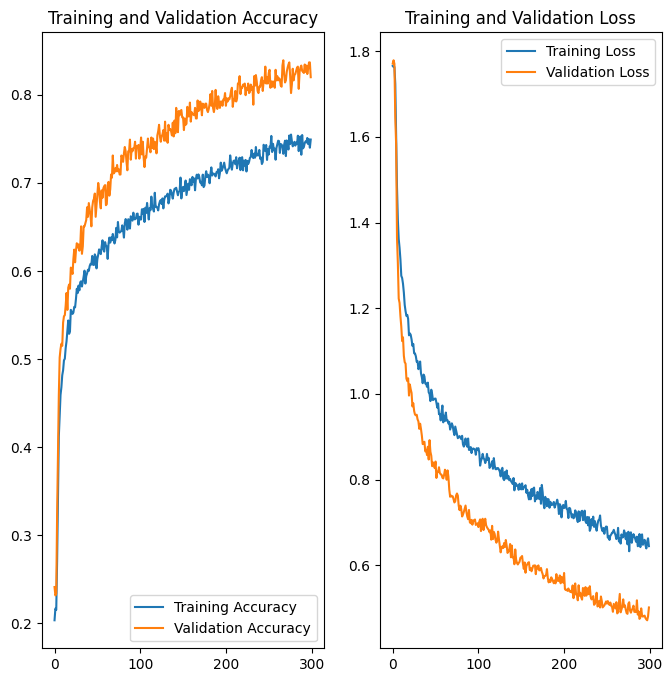

In [235]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Inference

Lets visualise inferred probabilities for validation and test sets.

1/1 [==============================] - 0s 329ms/step


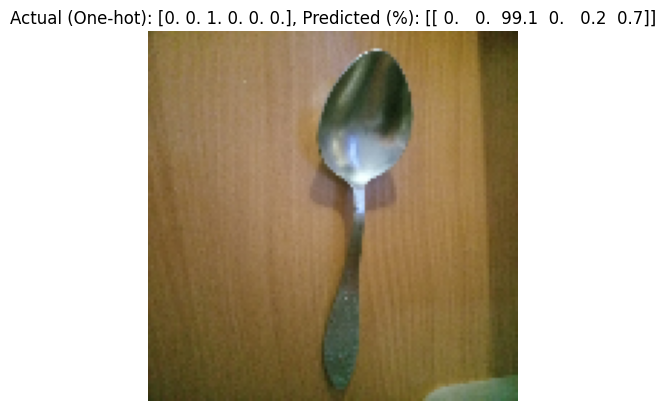

1/1 [==============================] - 0s 63ms/step


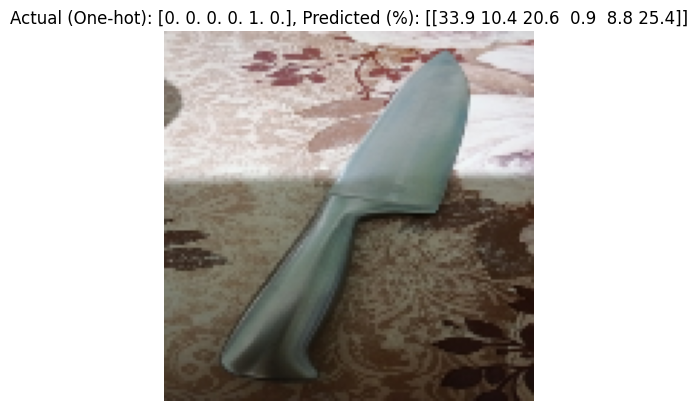

1/1 [==============================] - 0s 115ms/step


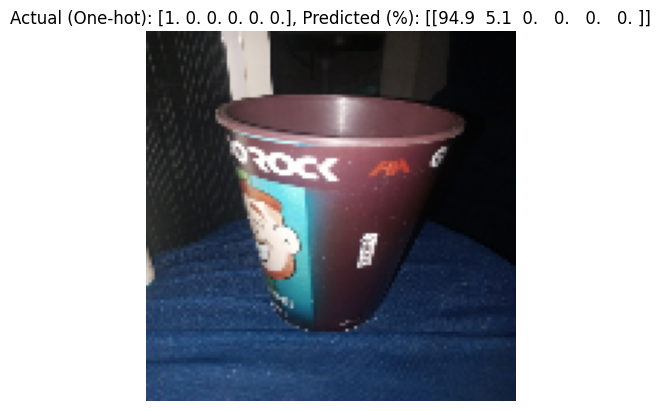

1/1 [==============================] - 0s 111ms/step


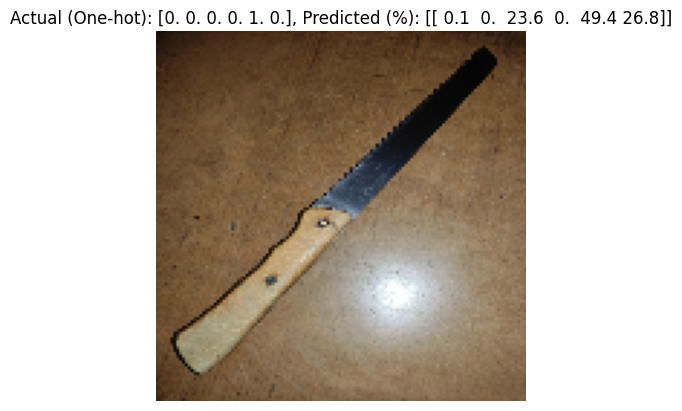

1/1 [==============================] - 0s 19ms/step


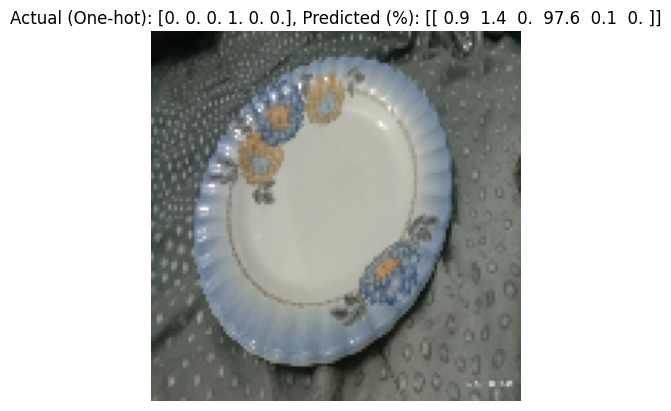

1/1 [==============================] - 0s 21ms/step


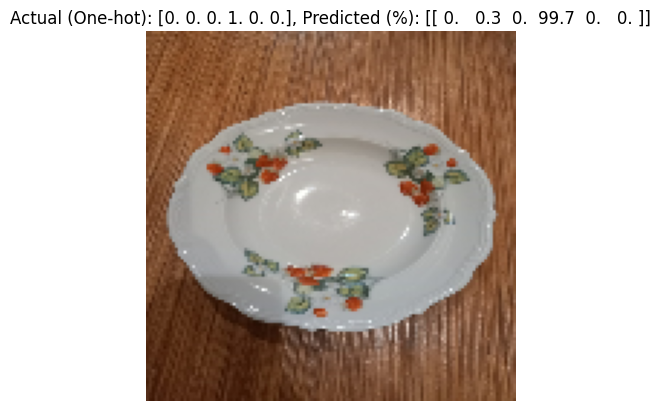

In [236]:
for image, label in val_ds.take(2):
    for i in range(3):
        single_image = image[i]
        single_prediction = model.predict(tf.expand_dims(single_image, 0))
        show(single_image, label[i], single_prediction)

1/1 [==============================] - 0s 44ms/step


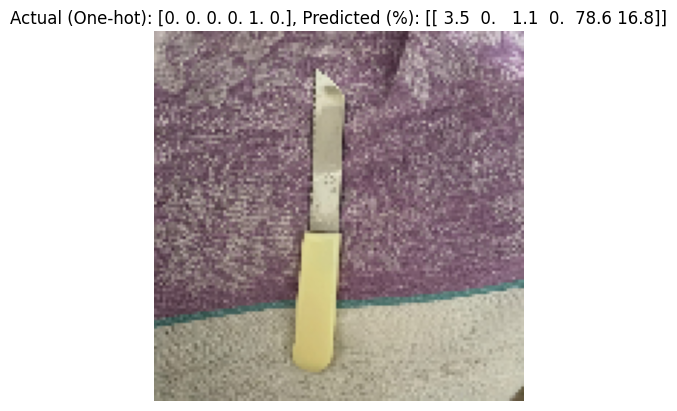

1/1 [==============================] - 0s 58ms/step


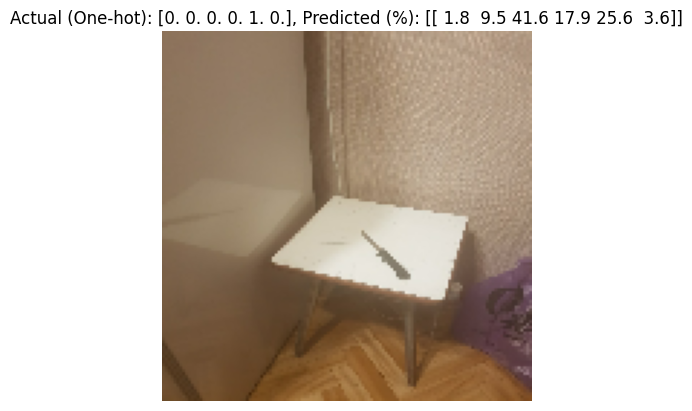

1/1 [==============================] - 0s 31ms/step


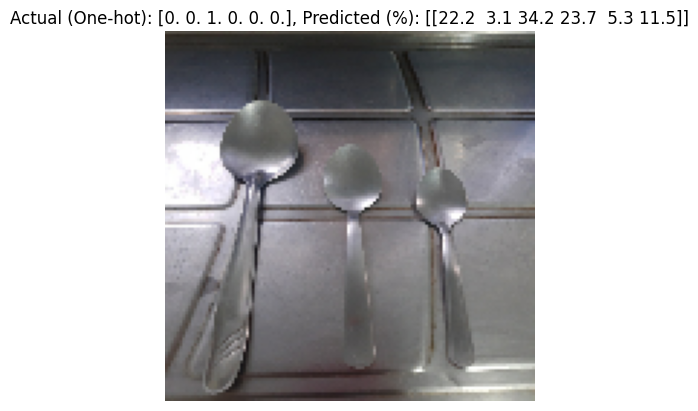

1/1 [==============================] - 0s 31ms/step


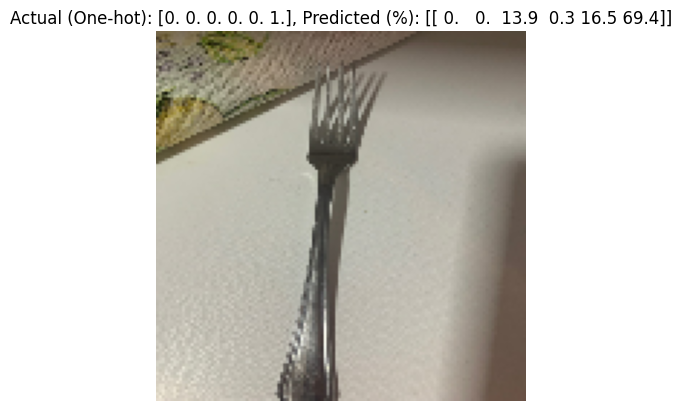

1/1 [==============================] - 0s 29ms/step


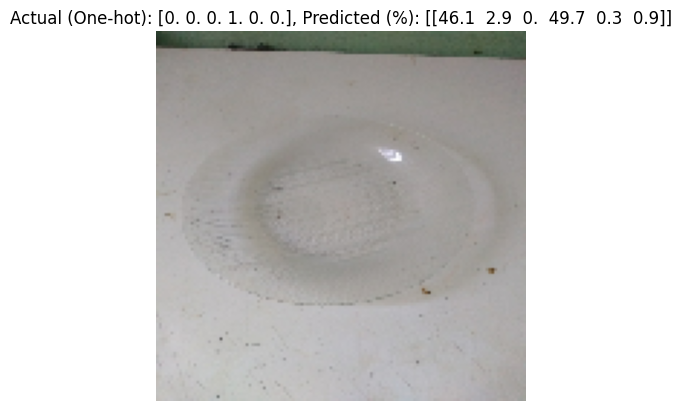

1/1 [==============================] - 0s 38ms/step


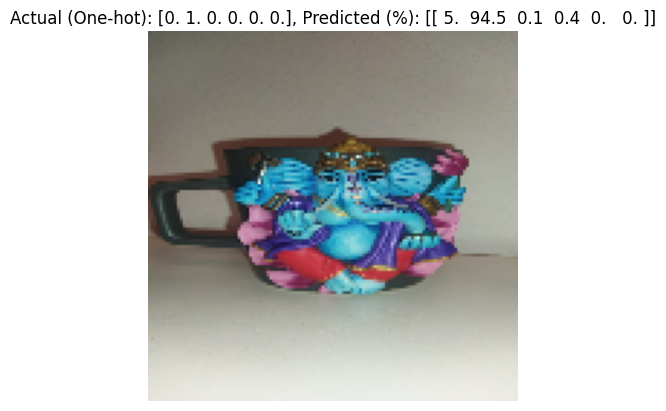

In [238]:
for image, label in test_ds.take(2):
    for i in range(3):
        single_image = image[i]
        single_prediction = model.predict(tf.expand_dims(single_image, 0))
        show(single_image, label[i], single_prediction)

Inference from a smartphone picture of a cup which I took when finished training this model

1/1 [==============================] - 0s 19ms/step


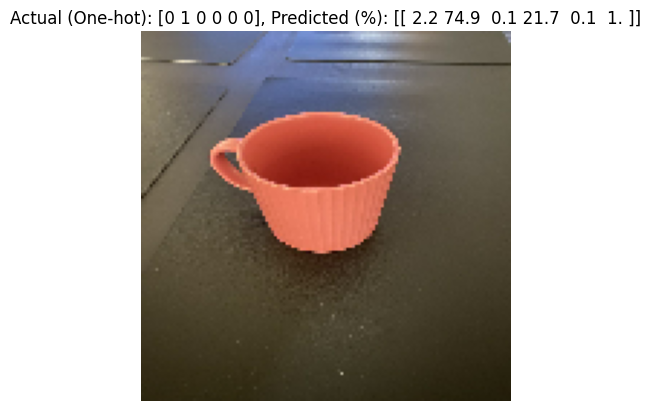

In [239]:
my_img_filename = datapath + 'my_img.jpg'

image = tf.io.read_file(my_img_filename)
image = tf.io.decode_jpeg(image)
image = tf.image.convert_image_dtype(image, tf.float32)
image = tf.image.resize(image, [128, 128])
image = tf.expand_dims(image, 0)

predictions = model.predict(image)


show(image[0], tf.convert_to_tensor(np.array([0, 1, 0, 0, 0, 0])), predictions)